# Pattern Recognition - Lab2
## Speech Recognition with HMMs and RNNs

##### Dimitris Dimos - 031 17 165
##### Konstantinos Kopsinis - 031 17 062

## Requirements

In [ ]:
!pip install gensim==3.8.1 matplotlib==3.1.0 nltk==3.4.4 numpy==1.16.4 pandas==0.24.2 pomegranate==0.12.0 scikit-image==0.15.0 scikit-learn==0.21.2 scipy==1.3.0 seaborn==0.9.0 torch==1.3.1 torchvision==0.4.2 tqdm==4.32.1 joblib==0.17.0
!pip install numba==0.48.0 --ignore-installed
!pip install librosa==0.7.1
!pip install word2number

## Imports

In [ ]:
# aux
import os
import IPython.display as ipd
from word2number import w2n
import random

# miscellaneous
import librosa
import pandas
import numpy as np
import itertools
from pomegranate import *

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sci-kit learn
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# pytorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# suppress some annoying/unimportant warnings
import warnings
warnings.filterwarnings("ignore")

# custom Naive Bayes
%cd drive/My Drive/PatRec_Labs/Lab2
import lab1_NB

# main lab aux code
from lab2_aux_code.parser import *
from lab2_aux_code.lstm import *
from lab2_aux_code.plot_confusion_matrix import *

## Step 2: Custom Data Parser

In [ ]:
samples = 133

def data_parser(directory):
    wav_file = [None] * samples
    speaker = np.zeros(samples, dtype=int)
    digit = np.zeros(samples, dtype=int)
    
    for i, file in enumerate(os.listdir(directory)):
        filename = os.fsdecode(file)
        wav_file[i], _ = librosa.load(os.path.join(directory, filename), sr=16000)
        digit_speaker = filename.split('.')[0]  # Keep speaker and digit

        # extract digit
        d = ""
        for c in digit_speaker:
            if c.isalpha():
                d += c
        digit[i] = w2n.word_to_num(d)

        # extract speaker
        s = ""
        for c in digit_speaker:
            if not c.isalpha():
                s += c
        speaker[i] = w2n.word_to_num(s)
     
    return wav_file, speaker, digit

In [ ]:
data_dir = "pr_lab2_data/digits"
wav_file, speaker, digit = data_parser(data_dir)

print("First 4 parsed files:\n")
for i in range(4):
    print("wav_file {}: speaker={}, digit={}".format(i+1,speaker[i],digit[i]))

First 4 parsed files:

wav_file 1: speaker=13, digit=9
wav_file 2: speaker=7, digit=4
wav_file 3: speaker=10, digit=3
wav_file 4: speaker=15, digit=8


In [ ]:
# doublechecking if our parser works correctly

number_dict = {1:'one', 2:'two', 3:'three', 4:'four', 5:'five',
               6:'six', 7:'seven', 8:'eight', 9:'nine'}

sample = random.randint(0,samples-1)    # select a random number
# convert parsed data back into filename
name = number_dict[digit[sample]].lower() + str(speaker[sample]) + '.wav'
print(name)

# listen check
ipd.Audio("./pr_lab2_data/digits/" + name)

eight11.wav


## Step 3: Extract MFCCs

In [ ]:
sr = 16000 # sampling rate
n_mfcc = 13
window_length = 0.025
hop_length = 0.010

# convert time lengths to points, to match librosas parameters
n_fft = int (sr * window_length)  
hop_length = int (sr * hop_length)

mfccs = []
delta = []
delta_delta = []

# extracting MFCCs, 1st and 2nd order derivatives of MFCCs
for i in range(samples):
    mfcc = librosa.feature.mfcc(wav_file[i], sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta_delta_mfcc = librosa.feature.delta(mfcc, order=2)

    mfccs.append(mfcc)
    delta.append(delta_mfcc)
    delta_delta.append(delta_delta_mfcc)

## Step 4: MFCCs Histograms

In [ ]:
# AM1: 031 17 165 --> n1 = 5
# AM2: 031 17 062 --> n2 = 2

n1 = 5
n2 = 2

mfcc1_n1 = []
mfcc2_n1 = []

mfcc1_n2 = []
mfcc2_n2 = []

for i in range(samples):
    if digit[i] == n1:
        mfcc1_n1.append(mfccs[i][0])
        mfcc2_n1.append(mfccs[i][1])
    
    if digit[i] == n2:
        mfcc1_n2.append(mfccs[i][0])
        mfcc2_n2.append(mfccs[i][1])

# we flatten our MFCC list of lists, so as to plug it in histogram
mfcc1_n1_flattened = list(itertools.chain.from_iterable(mfcc1_n1))
mfcc2_n1_flattened = list(itertools.chain.from_iterable(mfcc2_n1))
mfcc1_n2_flattened = list(itertools.chain.from_iterable(mfcc1_n2))
mfcc2_n2_flattened = list(itertools.chain.from_iterable(mfcc2_n2))

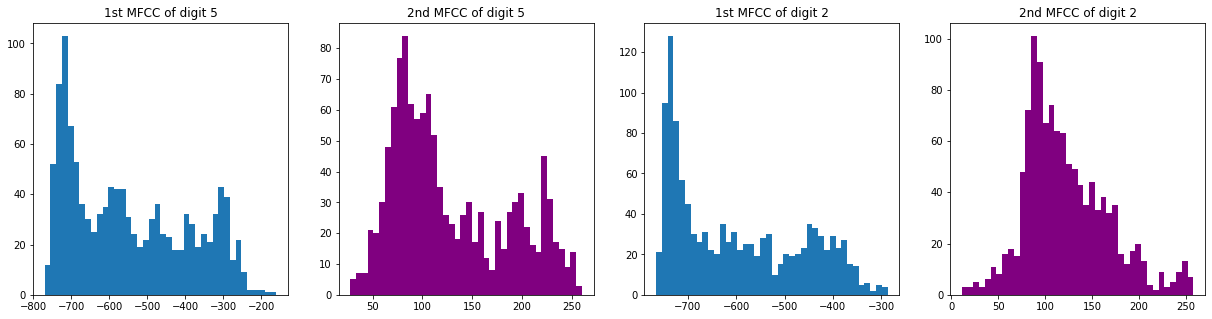

In [ ]:
# plotting histograms
fig = plt.figure(figsize=(21,5))
ax1 = fig.add_subplot(1, 4, 1)
plt.hist(mfcc1_n1_flattened, bins=40)
ax1.title.set_text('1st MFCC of digit {}'.format(n1))

ax2 = fig.add_subplot(1, 4, 2)
plt.hist(mfcc2_n1_flattened, bins=40, color='purple')
ax2.title.set_text('2nd MFCC of digit {}'.format(n1))

ax2 = fig.add_subplot(1, 4, 3)
plt.hist(mfcc1_n2_flattened, bins=40)
ax2.title.set_text('1st MFCC of digit {}'.format(n2))

ax2 = fig.add_subplot(1, 4, 4)
plt.hist(mfcc2_n2_flattened, bins=40, color = 'purple')
ax2.title.set_text('2nd MFCC of digit {}'.format(n2))

plt.show()

In [ ]:
speaker1 = 3
speaker2 = 4

# collect the specific speaker-digit data
speaker1_n1 = np.where( (speaker == speaker1) & (digit == n1) )[0][0]
speaker1_n2 = np.where( (speaker == speaker1) & (digit == n2) )[0][0]
speaker2_n1 = np.where( (speaker == speaker2) & (digit == n1) )[0][0]
speaker2_n2 = np.where( (speaker == speaker2) & (digit == n2) )[0][0]

print("Index for Speaker No {} pronouncing Digit No {}: ".format(speaker1, n1) + str(speaker1_n1))
print("Index for Speaker No {} pronouncing Digit No {}: ".format(speaker1, n2) + str(speaker1_n2))
print("Index for Speaker No {} pronouncing Digit No {}: ".format(speaker2, n1) + str(speaker2_n1))
print("Index for Speaker No {} pronouncing Digit No {}: ".format(speaker2, n2) + str(speaker2_n2))

Index for Speaker No 3 pronouncing Digit No 5: 32
Index for Speaker No 3 pronouncing Digit No 2: 107
Index for Speaker No 4 pronouncing Digit No 5: 49
Index for Speaker No 4 pronouncing Digit No 2: 104


In [ ]:
# extract MFSCs
mfsc1_n1 = librosa.feature.melspectrogram(wav_file[speaker1_n1], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfsc1_n2 = librosa.feature.melspectrogram(wav_file[speaker1_n2], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfsc2_n1 = librosa.feature.melspectrogram(wav_file[speaker2_n1], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)
mfsc2_n2 = librosa.feature.melspectrogram(wav_file[speaker2_n2], sr=sr, hop_length=hop_length, n_fft=n_fft, n_mels=13)

In [ ]:
def plot_correlation(f1, f2, f3, f4, what):
    fig = plt.figure(figsize=(21,5))

    ax1 = fig.add_subplot(1, 4, 1)
    toPlot = pandas.DataFrame.from_records(f1.T)
    plt.imshow(toPlot.corr(), cmap='winter')
    ax1.title.set_text('Correlation of {} for Speaker {}, Digit {}'.format(what, speaker1, n1))

    ax2 = fig.add_subplot(1, 4, 2)
    toPlot = pandas.DataFrame.from_records(f2.T)
    plt.imshow(toPlot.corr(), cmap = 'Wistia')
    ax2.title.set_text('Correlation of {} for Speaker {}, Digit {}'.format(what, speaker1, n2))

    ax3 = fig.add_subplot(1, 4, 3)
    toPlot = pandas.DataFrame.from_records(f3.T)
    plt.imshow(toPlot.corr(), cmap='winter')
    ax3.title.set_text('Correlation of {} for Speaker {}, Digit {}'.format(what, speaker2, n1))

    ax4 = fig.add_subplot(1, 4, 4)
    toPlot = pandas.DataFrame.from_records(f4.T)
    plt.imshow(toPlot.corr(), cmap = 'Wistia')
    ax4.title.set_text('Correlation of {} for Speaker {}, Digit {}'.format(what, speaker2, n2))

    plt.show()

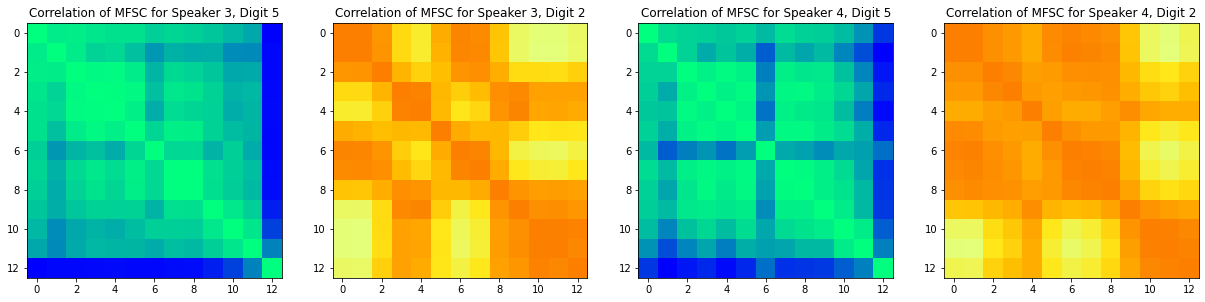

In [ ]:
plot_correlation(mfsc1_n1, mfsc1_n2, mfsc2_n1, mfsc2_n2, 'MFSC')

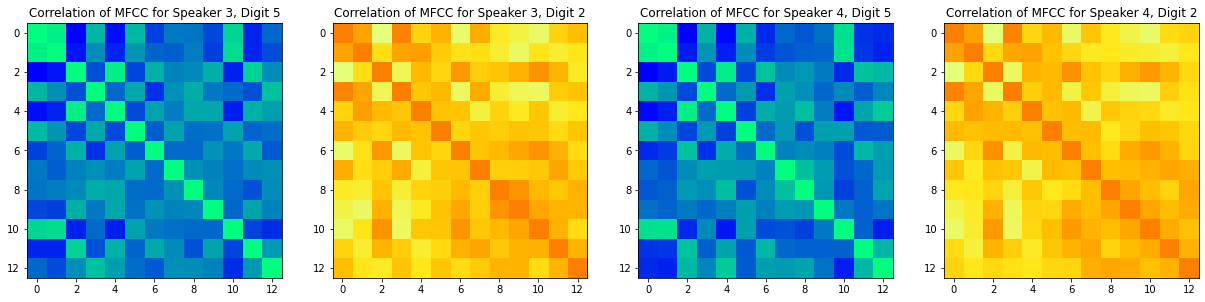

In [ ]:
plot_correlation(mfccs[speaker1_n1], mfccs[speaker1_n2], mfccs[speaker2_n1], mfccs[speaker2_n2], 'MFCC')

## Step 5: Feature Vector Extraction

In [ ]:
# we define the unique feature vector for each recording to be the concatenation of:
# mean_mfcc + mean_delta + mean_delta_delta + var_mfcc + var_delta + var_delta_delta
feature_vector = np.zeros((samples, 6*13))

for record in range(samples):
    feature_vector[record,   :13] = np.mean(mfccs[record], axis=1)
    feature_vector[record, 13:26] = np.mean(delta[record], axis=1)
    feature_vector[record, 26:39] = np.mean(delta_delta[record], axis=1)
    feature_vector[record, 39:52] = np.std(mfccs[record], axis=1)
    feature_vector[record, 52:65] = np.std(delta[record], axis=1)
    feature_vector[record, 65:  ] = np.std(delta_delta[record], axis=1)

In [ ]:
colors = ['blue', 'black', 'orange', 'pink', 'gray', 'green', 'purple', 'brown', 'red']
shapes = ['.', 'o', 'v', '^', 'x', 'D', "X", 's', 'P']
labels = [i for i in range(1,10)]

# plotting two dimsensions of input vectors
def scattering(X, y, dim=2):
    plt.rcParams['figure.figsize'] = [8, 6]
    if dim == 2:
        fig, ax = plt.subplots()
        X0 = X[:, 0]
        X1 = X[:, 1]
        for i in range(9):
            ax.scatter(X0[y == i+1], X1[y == i+1], c=colors[i], marker = shapes[i],
                    label=labels[i], s=80, alpha=1, edgecolors=colors[i])
            
    if dim == 3:
        fig = plt.figure()
        ax = plt.axes(projection ="3d")
        X0 = X[:, 0]
        X1 = X[:, 1]
        X2 = X[:, 2]
        for i in range(9):
            ax.scatter3D(X0[y == i+1], X1[y == i+1], X2[y == i+1], c=colors[i], marker = shapes[i],
                    label=labels[i], s=30, alpha=1, edgecolors=colors[i])

    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    plt.show()

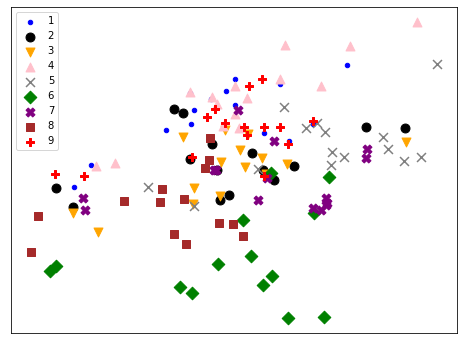

In [ ]:
scattering(feature_vector[:,:39], digit, dim=2) # plot the means in the feature vectors

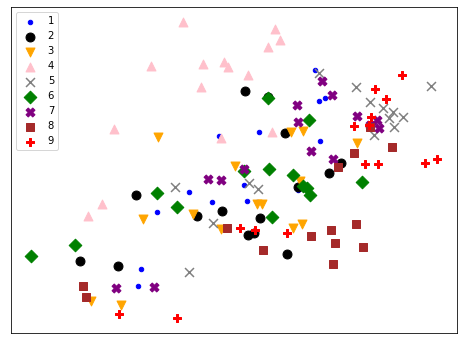

In [ ]:
scattering(feature_vector[:,39:], digit, dim=2) # plot the vars in the feature vectors

## Step 6: Principal Component Analysis

In [ ]:
# apply PCA

pca2D_mean = PCA(n_components=2)
pca2D_var  = PCA(n_components=2)
pca3D_mean = PCA(n_components=3)
pca3D_var  = PCA(n_components=3)
pca2D_mean_var = PCA(n_components=2)
pca3D_mean_var = PCA(n_components=3)

feature_vector_2D_mean = pca2D_mean.fit_transform(feature_vector[:,39:])
print(pca2D_mean.explained_variance_ratio_)

feature_vector_2D_var  = pca2D_var.fit_transform(feature_vector[:,:39])
print(pca2D_var.explained_variance_ratio_)

feature_vector_3D_mean = pca3D_mean.fit_transform(feature_vector[:,39:])
print(pca3D_mean.explained_variance_ratio_)

feature_vector_3D_var  = pca3D_var.fit_transform(feature_vector[:,:39])
print(pca3D_var.explained_variance_ratio_)

feature_vector_2D_mean_var  = pca2D_mean_var.fit_transform(feature_vector)
print(pca2D_mean_var.explained_variance_ratio_)

feature_vector_3D_mean_var  = pca3D_mean_var.fit_transform(feature_vector)
print(pca3D_mean_var.explained_variance_ratio_)

[0.67739631 0.16162278]
[0.6702432  0.15044095]
[0.67739631 0.16162278 0.06803315]
[0.6702432  0.15044095 0.06210854]
[0.58803289 0.1185675 ]
[0.58803289 0.1185675  0.10831836]


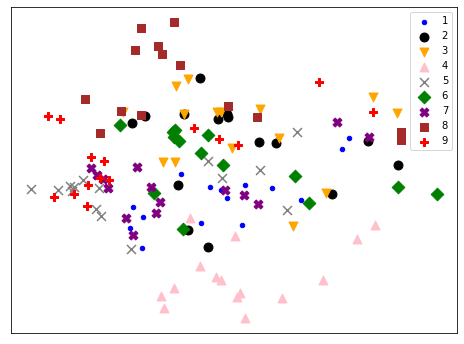

In [ ]:
scattering(feature_vector_2D_mean, digit, dim=2)

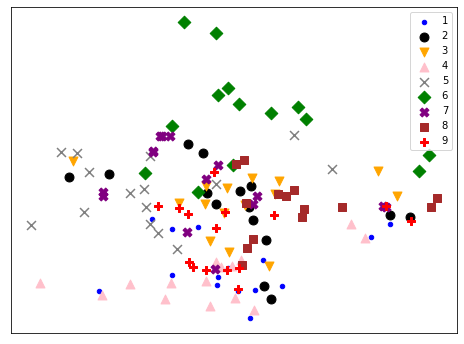

In [ ]:
scattering(feature_vector_2D_var, digit, dim=2)

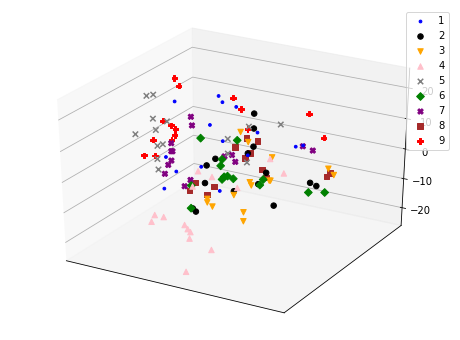

In [ ]:
scattering(feature_vector_3D_mean, digit, dim=3)

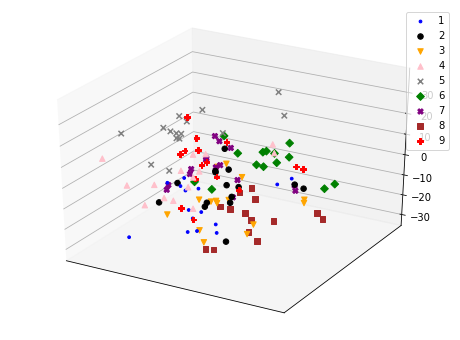

In [ ]:
scattering(feature_vector_3D_var, digit, dim=3)

## Step 7: Classification (Custom NB, scikit NB, SVM, KNN, Logistic Regression)

In [ ]:
# split data into train (70%) and test (30%) 
X_train, X_test, y_train, y_test = train_test_split(feature_vector, digit, test_size=0.3, stratify=digit)
# normalize data
X_train = preprocessing.normalize(X_train)
X_test  = preprocessing.normalize(X_test)

In [ ]:
def classify(x_dim=78):

    # custom Naive Bayes
    custom_NBClassifier = lab1_NB.CustomNBClassifier(x_dim=x_dim)
    custom_NBClassifier.fit(X_train, y_train)
    print("Custom NB Classifier")
    print(custom_NBClassifier.score(X_test, y_test))

    # scikit Naive Bayes
    scikit_NBClassifier = GaussianNB()
    scikit_NBClassifier.fit(X_train, y_train)
    print("Scikit NB Classifier")
    print(scikit_NBClassifier.score(X_test, y_test))

    # SVM linear kernel
    svm_linear = SVC(kernel="linear", probability=True) 
    svm_linear.fit(X_train, y_train)
    print("SVM (linear kernel) Classifier")
    print(svm_linear.score(X_test, y_test))

    # KNN classifier (3 neighbours)
    KNN_3 = KNeighborsClassifier(n_neighbors = 3)
    KNN_3.fit(X_train, y_train)
    print("KNN (3 neighbors) Classifier")
    print(KNN_3.score(X_test, y_test))

    # Logistic Regression
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    print("Logistic Regression Classifier")
    print(logistic_regression.score(X_test, y_test))

In [ ]:
classify()

Custom NB Classifier
0.5
Scikit NB Classifier
0.525
SVM (linear kernel) Classifier
0.175
KNN (3 neighbors) Classifier
0.475
Logistic Regression Classifier
0.175


In [ ]:
# bonus: extract zero-crossing rate
zero_crossing_rate = []
for i in range(samples):
    zc = librosa.feature.zero_crossing_rate(wav_file[i], frame_length=int(sr*window_length), hop_length=hop_length)[:, :53]
    zero_crossing_rate.append(zc)

feature_vector_zc = np.zeros((samples, 6*13+53))
for record in range(samples):
    feature_vector_zc[record,   :78] = feature_vector[record]
    feature_vector_zc[record, 78:  ] = zero_crossing_rate[record][0]

In [ ]:
# repeat for extended feature vectors
X_train, X_test, y_train, y_test = train_test_split(feature_vector_zc, digit, test_size=0.3, stratify=digit)

X_train = preprocessing.normalize(X_train)
X_test  = preprocessing.normalize(X_test)

classify(x_dim = 6*13+53)

Custom NB Classifier
0.6
Scikit NB Classifier
0.625
SVM (linear kernel) Classifier
0.225
KNN (3 neighbors) Classifier
0.55
Logistic Regression Classifier
0.225


## Step 8: Intro Pytorch - RNNs, LSTM, GRU

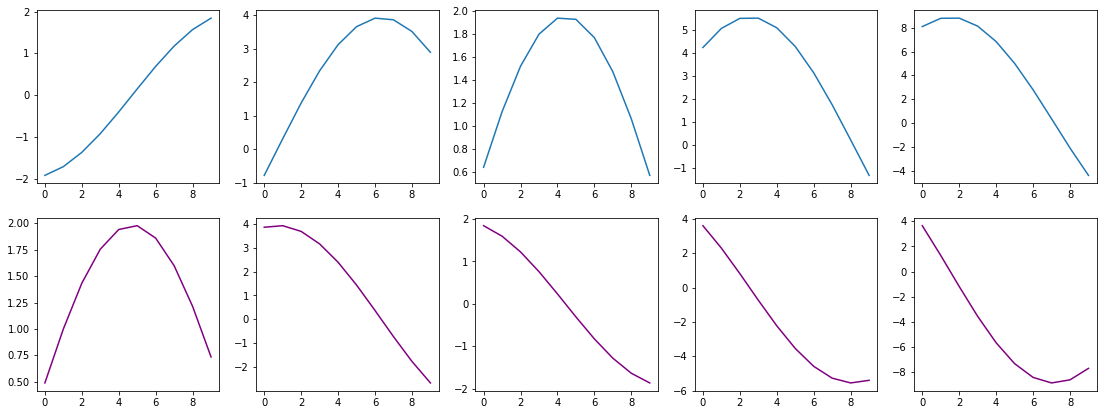

In [ ]:
# create data
f = 40
T = 1/f
w = 2*np.pi*f
n_seq = 1000   # number of sinus sequences
n_points = 10  # sample points

sin_waves = np.zeros((n_seq, n_points))
cos_waves = np.zeros((n_seq, n_points))

for i in range(n_seq):
    
    A = np.random.uniform(1,10)
    start = np.random.uniform(0, T)
    final = start + n_points*0.001  # bring the points close together
    t = np.linspace(start, final, n_points)
    
    sin_waves[i] = A*np.sin(w*t)
    cos_waves[i] = A*np.cos(w*t)


# we plot some of our generated data
fig = plt.figure(figsize=(19,7))
for i in range(5):  # sinus
    fig.add_subplot(2, 5, i+1)
    plt.plot(np.arange(10), sin_waves[i])
for i in range(5): # cosine
    fig.add_subplot(2, 5, i+6)
    plt.plot(np.arange(10), cos_waves[i], color='purple')
plt.show()

In [ ]:
# prepare the data
X_train, X_test, y_train, y_test = train_test_split(sin_waves, cos_waves, test_size = 0.3)
X_train = torch.from_numpy(X_train).double()
X_test  = torch.from_numpy(X_test).double()
y_train = torch.from_numpy(y_train).double()
y_test  = torch.from_numpy(y_test).double()

In [ ]:
# training function
def train(model, X_train, y_train, X_test, y_test, criterion, optimizer, epochs, toPlot=False):

    train_running_losses = []
    test_running_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()   # zero out the gradient
        y_pred = model(X_train)
        train_loss = criterion(y_pred, y_train)
        train_loss.backward()
        optimizer.step()

        with torch.no_grad():   # predict on test data
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
            
        if (epoch+1)%200 == 0:  # print the losses for every 500th iteration
            print("Epoch {}: Training Loss {} \t--\t Test Loss {}".format(epoch+1, train_loss.item(), test_loss.item()))

        # collect the losses, to plot them afterwards
        train_running_losses.append(train_loss.item())
        test_running_losses.append(test_loss.item())

    if toPlot == True:   # plot the losses
        plt.rcParams['figure.figsize'] = [6,4]
        plt.figure()
        plt.plot(np.arange(epochs), train_running_losses, label='Training Loss', color='blue')
        plt.plot(np.arange(epochs), test_running_losses,  label='Training Loss', color='orange')
        plt.title('Losses during training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return train_running_losses, test_running_losses

In [ ]:
# custom vanilla RNN
class MyRNN(nn.Module):
    def __init__(self, input_size=1, num_layers=1, hidden_size=64, output_size=1, activation = 'relu'):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          nonlinearity=activation,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        outputs = []
        
        ht = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.double)
        for i, x_t in enumerate(x.chunk(x.size(1), dim=1)):
            output, ht = self.rnn(x_t.unsqueeze(-1), ht)
            output = self.fc(ht)
            outputs.append(output[0])
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
# custom LSTM
class MyLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        outputs = []
        batch_size = x.size(0)  # we do not split into batches

        # initialize hidden and cell states
        ht = torch.zeros(batch_size, self.hidden_size, dtype=torch.double)
        ct = torch.zeros(batch_size, self.hidden_size, dtype=torch.double)
        
        for i, x_t in enumerate(x.chunk(x.size(1), dim=1)):
            ht, ct = self.lstm(x_t, (ht, ct))
            output = self.fc(ht)
            outputs.append(output)
        outputs = torch.stack(outputs, 1).squeeze(2)

        return outputs

In [ ]:
# custom GRU
class MyGRU(nn.Module):

    def __init__(self, input_size=1, num_layers=1, hidden_size=64, output_size=1, activation = 'relu'):

        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        outputs = []
        
        ht = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.double)
        for i, x_t in enumerate(x.chunk(x.size(1), dim=1)):
            output, ht = self.gru(x_t.unsqueeze(-1), ht)
            output = self.fc(ht)
            outputs.append(output[0])
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
# hyperparameters
criterion = nn.MSELoss()
epochs = 1000
learning_rate = 10e-3

Epoch 200: Training Loss 1.8295579949686596 	--	 Test Loss 1.8652669273709626
Epoch 400: Training Loss 1.8071796990110525 	--	 Test Loss 1.8435811231197183
Epoch 600: Training Loss 1.8053627003003128 	--	 Test Loss 1.8419715379087294
Epoch 800: Training Loss 1.8506538961708952 	--	 Test Loss 1.8831365128518815
Epoch 1000: Training Loss 1.8058955129960126 	--	 Test Loss 1.845209999206715


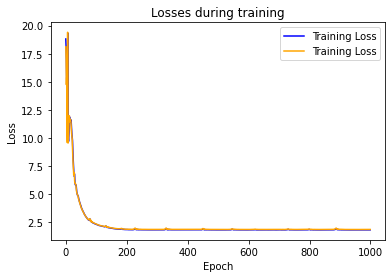

In [ ]:
# train vanilla RNN
RNN = MyRNN(hidden_size=64).double()
optimizer = torch.optim.Adam(RNN.parameters(), lr=learning_rate)
_ = train(RNN, X_train, y_train, X_test, y_test, criterion, optimizer, epochs, toPlot=True)

Epoch 200: Training Loss 1.8244140056508742 	--	 Test Loss 1.8742647481087715
Epoch 400: Training Loss 1.8058429135902305 	--	 Test Loss 1.84560072471088
Epoch 600: Training Loss 1.8006086989797696 	--	 Test Loss 1.839231306952346
Epoch 800: Training Loss 1.798010908764969 	--	 Test Loss 1.8375030562709191
Epoch 1000: Training Loss 1.7969689301278777 	--	 Test Loss 1.838999626399083


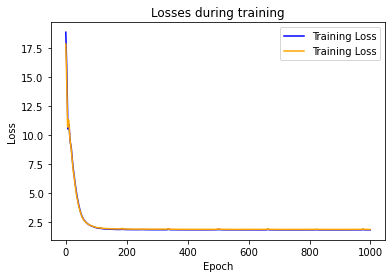

In [ ]:
# train LSTM
LSTM = MyLSTM(hidden_size=64).double()
optimizer = torch.optim.Adam(LSTM.parameters(), lr=learning_rate)
_ = train(LSTM, X_train, y_train, X_test, y_test, criterion, optimizer, epochs, toPlot=True)

Epoch 200: Training Loss 1.8240563435182404 	--	 Test Loss 1.8595141862390425
Epoch 400: Training Loss 1.804412757044834 	--	 Test Loss 1.842787160233814
Epoch 600: Training Loss 1.800824375951682 	--	 Test Loss 1.8395688160877857
Epoch 800: Training Loss 1.7980626911982212 	--	 Test Loss 1.837897193581958
Epoch 1000: Training Loss 1.7962094792838657 	--	 Test Loss 1.8377003839302615


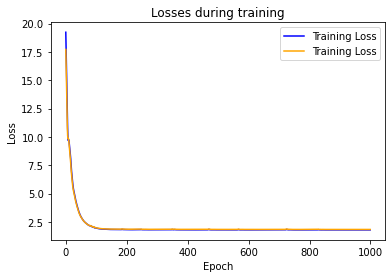

In [ ]:
# train GRU
GRU = MyGRU(hidden_size=64).double()
optimizer = torch.optim.Adam(GRU.parameters(), lr=learning_rate)
_ = train(GRU, X_train, y_train, X_test, y_test, criterion, optimizer, epochs, toPlot=True)

In [ ]:
# plot some cosine predictions
outputs_RNN = RNN.forward(X_test[:5, :]).detach().numpy()
outputs_LSTM = LSTM.forward(X_test[:5, :]).detach().numpy()
outputs_GRU = GRU.forward(X_test[:5, :]).detach().numpy()

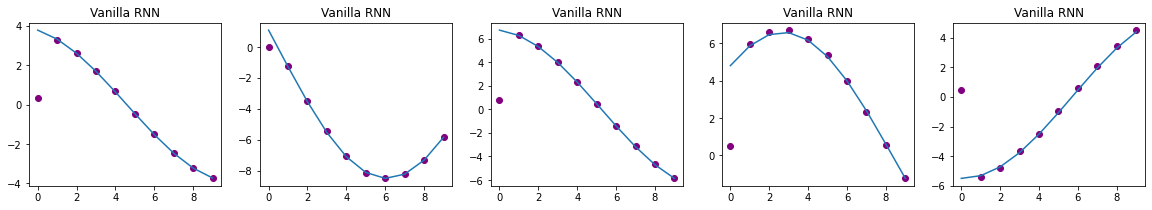

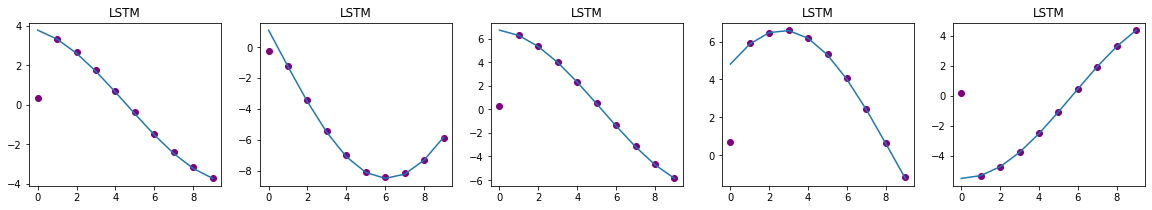

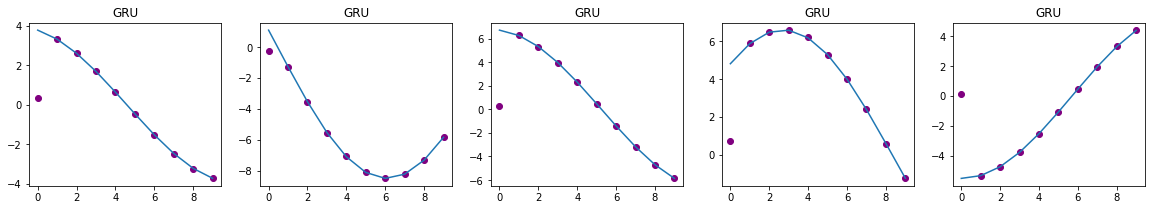

In [ ]:
fig = plt.figure(figsize=(20,3))
for i in range(1,6):
    fig.add_subplot(1, 5, i)
    plt.plot(np.arange(10), y_test[i-1])
    plt.scatter(np.arange(10), outputs_RNN[i-1], color='purple')
    plt.title('Vanilla RNN')

fig = plt.figure(figsize=(20,3))
for i in range(1,6):
    fig.add_subplot(1, 5, i)
    plt.plot(np.arange(10), y_test[i-1])
    plt.scatter(np.arange(10), outputs_LSTM[i-1], color='purple')
    plt.title('LSTM')

fig = plt.figure(figsize=(20,3))
for i in range(1,6):
    fig.add_subplot(1, 5, i)
    plt.plot(np.arange(10), y_test[i-1])
    plt.scatter(np.arange(10), outputs_GRU[i-1], color='purple')
    plt.title('GRU')

## Step 9: New Data Preprocessing

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!mv /content/drive/MyDrive/PatRec_Labs/Lab2/free-spoken-digit-dataset/recordings /content/drive/MyDrive/PatRec_Labs/Lab2/recordings

In [ ]:
# parse data
X_train, X_test, y_train, y_test, spk_train, spk_test = parser('recordings', n_mfcc=6)

# split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

# next, we normalize
scale_fn = make_scale_fn(X_train)
X_train = scale_fn(X_train)
X_val = scale_fn(X_val)
X_test = scale_fn(X_test)

Extracting mfcc features...:   1%|          | 16/3000 [00:00<00:18, 159.40it/s]

Total wavs: 3000. Fs = 8000 Hz


Extracting mfcc features...: 100%|██████████| 3000/3000 [00:21<00:00, 137.93it/s]


Feature extraction completed with 6 mfccs per frame
Splitting in train test split using the default dataset split
Normalization will be performed using mean: [-516.92143563   62.58665726   19.03391173    9.6942517   -19.23486873
  -10.84333083]
Normalization will be performed using std: [152.85964292  52.61580318  36.96156401  29.76810496  24.86718524
  23.4308293 ]


## Step 10: Gaussian Mixture Models – Hidden Markov Models (Definition and Training Algorithm)

In [ ]:
digits_separated = []   # in digits_separated[i] are the data corresponding to the i-th digit
# split data accordingly
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
for i in range(10):
    digits_separated.append(X_train_np[y_train_np==i])
    
def EM_algorithm(X, n_states, n_mixtures, gmm=True, max_iterations=30, stop_threshold=1e-9):
    dists = []
    for i in range(n_states):
        if gmm and n_mixtures>1:
            a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, n_mixtures, np.float_(np.vstack(X)))
        else:
            a = MultivariateGaussianDistribution.from_samples(np.float_(np.vstack(X)))
        dists.append(a)

    # transition matrix
    trans_mat = np.zeros((n_states,n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i == j or j == i+1:
                trans_mat[i,j] = 0.5  

    # starting probabilities
    starts = np.zeros(n_states)
    starts[0] = 1

    # ending probabilities
    ends = np.zeros(n_states)
    ends[-1] = 1

    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(n_states)])

    # Fit the model 
    model.fit(X, max_iterations=max_iterations, stop_threshold=stop_threshold)

    return model

## Step 11: Training the HMMs

In [ ]:
# training and collecting the HMMs
def train_HMM(X, n_states, n_mixtures, max_iterations, gmm=True, stop_threshold=1e-9):
    models = []
    for i in range(10):
        models.append(EM_algorithm(X[i], n_states, n_mixtures, max_iterations, gmm, stop_threshold))
    return models

## Step 12: Digit Recognition - Testing

In [ ]:
# function to evaluate models
def evaluate(HMMs, X, y):
    y_pred = [] # HMM predictions
    for seq in range(len(X)):
        logPs = []  # log likelihoods
        for HMM in range(10):
            logP, _ = HMMs[HMM].viterbi(X[seq])
            logPs.append(logP)
        y_pred.append(np.argmax(np.array(logPs)))
    
    accuracy = accuracy_score(y, y_pred)
    confusion_mat = confusion_matrix(y, y_pred)

    return accuracy, confusion_mat

In [ ]:
# hyperparameter optimization
%%capture

opt_accuracy = 0
for state in range(1,5):
    for mixture in range(1,6):
        for i in range(5,31,5):
            HMMs = train_HMM(digits_separated, state, mixture, True, i)
            accuracy, _ = evaluate(HMMs, X_val, y_val)
            if accuracy > opt_accuracy:
                opt_hp = [state, mixture, i]
                opt_HMMs = HMMs
                opt_accuracy = accuracy

In [ ]:
# collect the optimal hyperparameters
print("Optimal Number of States: {}".format(opt_hp[0]))
print("Optimal Number of Mixtures: {}".format(opt_hp[1]))
print("Optimal Number of Iterations: {}".format(opt_hp[2]))

Optimal Number of States: 4
Optimal Number of Mixtures: 5
Optimal Number of Iterations: 20


## Step 13: Confusion Matrix and Accuracy

In [ ]:
# Accuracies
val_accuracy, val_confusion_matrix = evaluate(opt_HMMs, X_val, y_val)
test_accuracy, test_confusion_matrix = evaluate(opt_HMMs, X_test, y_test)
print("Optimal accuracy on Validation Set: {}".format(val_accuracy))
print("Optimal accuracy on Test Set: {}".format(test_accuracy))

Optimal accuracy on Validation Set: 0.987037037037037
Optimal accuracy on Test Set: 0.96


Confusion matrix, without normalization
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  0  0  0  0  0  0]
 [ 0  0 54  0  0  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  1  0  0 52  0  1  0]
 [ 0  0  1  1  0  0  0 52  0  0]
 [ 0  0  0  0  0  1  0  0 53  0]
 [ 0  1  0  0  0  0  0  1  0 52]]


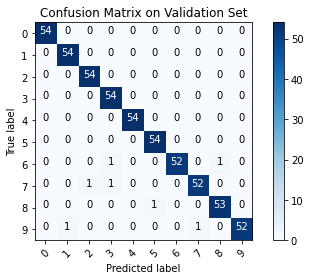

In [ ]:
# Confusion Matrices
plot_confusion_matrix(val_confusion_matrix,
                      classes = [0,1,2,3,4,5,6,7,8,9],
                      normalize=False,
                      title='Confusion Matrix on Validation Set',
                      cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 1  0  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  4  0  0 26  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  5  0 25  0]
 [ 0  1  0  0  0  0  0  1  0 28]]


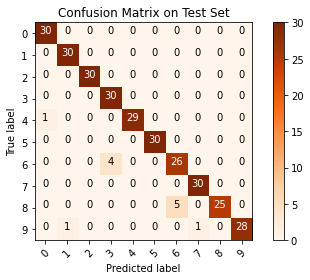

In [ ]:
plot_confusion_matrix(test_confusion_matrix,
                      classes = [0,1,2,3,4,5,6,7,8,9],
                      normalize=False,
                      title='Confusion Matrix on Test Set',
                      cmap=plt.cm.Oranges)

## Step 14: Speech Recognition using RNN - LSTMs

In [ ]:
# process data
batch_size = 128
epochs = 100
criterion = nn.CrossEntropyLoss()

train_set = FrameLevelDataset(X_train, y_train)
val_set = FrameLevelDataset(X_val, y_val)
test_set = FrameLevelDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
# define a new training function
def train2(model, dataloader, criterion, optimizer):    
    overall_loss = 0.0
    model.train()   # train mode
    for idx, batch in enumerate(dataloader, 1):

        inputs  = batch[0]
        labels  = batch[1]
        lengths = batch[2]
        
        optimizer.zero_grad()   # zero gradients out
        y_preds = model(inputs, lengths)    # forward propagate
        loss = criterion(y_preds, labels)   # compute loss function
        loss.backward() # compute gradients
        optimizer.step()    # update parameters

        overall_loss += loss.data.item()

    return overall_loss/idx   # train loss

In [ ]:
# neural network evaluator
def evaluate2(model, dataloader, criterion):
    overall_loss = 0.0
    y_gold = []
    y_pred = []
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for idx, batch in enumerate(dataloader, 1):
            
            inputs  = batch[0]
            labels  = batch[1]
            lengths = batch[2]
                
            y_preds = model(inputs, lengths)
            loss = criterion(y_preds, labels)
            prediction = torch.argmax(y_preds, dim=1)
            overall_loss += loss.data.item()
            
            y_pred.append(prediction.numpy())
            y_gold.append(labels.numpy())

    return overall_loss / idx, (y_gold, y_pred)

In [ ]:
# auxiliary training function
def train_aux2(model, optimizer, early_stopping=False, model_name=None):

    train_losses = []
    val_losses = []
    opt_loss = np.inf
    count = 0

    for epoch in range(epochs):
        train_loss = train2(model, train_loader, criterion, optimizer)
        val_loss, (y_gold, y_pred) = evaluate2(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("Epoch {}: Training Loss = {} \t--\t Validation Loss = {}".format(epoch, train_loss, val_loss))

        if early_stopping:
            if val_loss < opt_loss:
                torch.save(model, "./"+model_name) # checkpoint
                opt_loss = val_loss
                count = 0
            else:
                count += 1
            
            if count == 6:  # if it doesn't get any better, stop so as not to overfit
                print(' !!-- Terminated Training due to Early Stopping --!! ')
                break

    return train_losses, val_losses

In [ ]:
# subquestions (1), (2), (3), (4)
input_dim = X_train[0].shape[1]

LSTM_simple = BasicLSTM(input_dim=input_dim, rnn_size=128, output_dim=10, num_layers=1, bidirectional=False, dropout=0)
optimizer = torch.optim.Adam(LSTM_simple.parameters(), lr=1e-3)
train_losses, val_losses = train_aux2(LSTM_simple, optimizer)

Epoch 0: Training Loss = 2.2623650747186996 	--	 Validation Loss = 2.184475803375244
Epoch 1: Training Loss = 1.9632722560097189 	--	 Validation Loss = 1.7241246700286865
Epoch 2: Training Loss = 1.525816096979029 	--	 Validation Loss = 1.2997949123382568
Epoch 3: Training Loss = 1.1772871578440947 	--	 Validation Loss = 1.082769548892975
Epoch 4: Training Loss = 0.9425830525510451 	--	 Validation Loss = 0.8664832592010498
Epoch 5: Training Loss = 0.7621201276779175 	--	 Validation Loss = 0.8058864951133728
Epoch 6: Training Loss = 0.6693007525275735 	--	 Validation Loss = 0.6824295282363891
Epoch 7: Training Loss = 0.5658321590984569 	--	 Validation Loss = 0.534625232219696
Epoch 8: Training Loss = 0.47021859708954306 	--	 Validation Loss = 0.46951779127120974
Epoch 9: Training Loss = 0.39264873546712536 	--	 Validation Loss = 0.38820613622665406
Epoch 10: Training Loss = 0.3039361238479614 	--	 Validation Loss = 0.34997479915618895
Epoch 11: Training Loss = 0.26123879762256846 	--	 V

In [ ]:
# subquestion (5) - dropout (50%) and L2 regularization
LSTM_dropout_L2 = BasicLSTM(input_dim=input_dim, rnn_size=128, output_dim=10, num_layers=1, bidirectional=False, dropout=0.5)
optimizer = torch.optim.Adam(LSTM_dropout_L2.parameters(), lr=1e-3, weight_decay=1e-4) # L2 reg <-- weight decay
train_losses_dropout_L2, val_losses_dropout_L2 = train_aux2(LSTM_dropout_L2, optimizer)

Epoch 0: Training Loss = 2.2672693308661964 	--	 Validation Loss = 2.198343276977539
Epoch 1: Training Loss = 1.988938619108761 	--	 Validation Loss = 1.7727853536605835
Epoch 2: Training Loss = 1.609209839035483 	--	 Validation Loss = 1.46835298538208
Epoch 3: Training Loss = 1.3392781790565043 	--	 Validation Loss = 1.2049409866333007
Epoch 4: Training Loss = 1.0597715482992285 	--	 Validation Loss = 0.9895850658416748
Epoch 5: Training Loss = 0.8456038937849157 	--	 Validation Loss = 0.8091899394989014
Epoch 6: Training Loss = 0.6807583009495455 	--	 Validation Loss = 0.6168705344200134
Epoch 7: Training Loss = 0.5420461121727439 	--	 Validation Loss = 0.5131101906299591
Epoch 8: Training Loss = 0.40565036675509286 	--	 Validation Loss = 0.4396284520626068
Epoch 9: Training Loss = 0.3383780104272506 	--	 Validation Loss = 0.34568304419517515
Epoch 10: Training Loss = 0.28853781258358674 	--	 Validation Loss = 0.2996197730302811
Epoch 11: Training Loss = 0.2918517387965146 	--	 Valid

In [ ]:
# subquestion (6) - Early Stopping and Checkpoints
LSTM_early_check = BasicLSTM(input_dim=input_dim, rnn_size=128, output_dim=10, num_layers=1, bidirectional=False, dropout=0.5)
optimizer = torch.optim.Adam(LSTM_early_check.parameters(), lr=1e-3, weight_decay=1e-4) # L2 reg <-- weight decay
train_losses_early_check, val_losses_early_check = train_aux2(LSTM_early_check, optimizer, early_stopping=True, model_name='LSTM_early_check')

Epoch 0: Training Loss = 2.260728022631477 	--	 Validation Loss = 2.1808173179626467
Epoch 1: Training Loss = 1.9478040933609009 	--	 Validation Loss = 1.7271491765975953
Epoch 2: Training Loss = 1.584759046049679 	--	 Validation Loss = 1.4630209445953368
Epoch 3: Training Loss = 1.2921543752445894 	--	 Validation Loss = 1.1218393802642823
Epoch 4: Training Loss = 1.0259949494810665 	--	 Validation Loss = 0.9187253832817077
Epoch 5: Training Loss = 0.826356547720292 	--	 Validation Loss = 0.7957235693931579
Epoch 6: Training Loss = 0.6677289184402017 	--	 Validation Loss = 0.62190922498703
Epoch 7: Training Loss = 0.5061859856633579 	--	 Validation Loss = 0.4396993577480316
Epoch 8: Training Loss = 0.39730976083699393 	--	 Validation Loss = 0.4239635765552521
Epoch 9: Training Loss = 0.3455697823973263 	--	 Validation Loss = 0.39230401515960694
Epoch 10: Training Loss = 0.27922865573097677 	--	 Validation Loss = 0.271933314204216
Epoch 11: Training Loss = 0.22672030505012064 	--	 Valid

In [ ]:
# subquestion (7) - bidirectional LSTM
LSTM_bidirect = BasicLSTM(input_dim=input_dim, rnn_size=128, output_dim=10, num_layers=1, bidirectional=True, dropout=0.5)
optimizer = torch.optim.Adam(LSTM_bidirect.parameters(), lr=1e-3, weight_decay=1e-4) # L2 reg <-- weight decay
train_losses_bidirect, val_losses_bidirect = train_aux2(LSTM_bidirect, optimizer, early_stopping=True, model_name='LSTM_bidirect')

Epoch 0: Training Loss = 2.2216599268071793 	--	 Validation Loss = 2.073169803619385
Epoch 1: Training Loss = 1.6903999412761015 	--	 Validation Loss = 1.3291590452194213
Epoch 2: Training Loss = 1.085901579436134 	--	 Validation Loss = 0.9138841986656189
Epoch 3: Training Loss = 0.6905861847540912 	--	 Validation Loss = 0.624508535861969
Epoch 4: Training Loss = 0.5000302756533903 	--	 Validation Loss = 0.447319883108139
Epoch 5: Training Loss = 0.38606547783402834 	--	 Validation Loss = 0.3457004904747009
Epoch 6: Training Loss = 0.28687459230422974 	--	 Validation Loss = 0.2885384142398834
Epoch 7: Training Loss = 0.223241727141773 	--	 Validation Loss = 0.22719979882240296
Epoch 8: Training Loss = 0.17242042194394505 	--	 Validation Loss = 0.19700102061033248
Epoch 9: Training Loss = 0.13864639445262797 	--	 Validation Loss = 0.212637859582901
Epoch 10: Training Loss = 0.12889068792848027 	--	 Validation Loss = 0.20377594828605652
Epoch 11: Training Loss = 0.14458962223109076 	--	 

In [ ]:
# accuracy and confusion matrix of best model
val_loss, (val_gold, val_pred) = evaluate2(LSTM_bidirect, val_loader, criterion)
test_loss, (test_gold, test_pred) = evaluate2(LSTM_bidirect, test_loader, criterion)

accuracy_val = accuracy_score(np.concatenate(val_gold), np.concatenate(val_pred))
accuracy_test = accuracy_score(np.concatenate(test_gold), np.concatenate(test_pred))
confusion_matrix_val = confusion_matrix(np.concatenate(val_gold), np.concatenate(val_pred))
confusion_matrix_test = confusion_matrix(np.concatenate(test_gold), np.concatenate(test_pred))

print("Best Model: Bidirectional LSTM - Accuracy on Validation Set: {} - Accuracy on Test Set: {}\n\n".format(accuracy_val, accuracy_test))

Best Model: Bidirectional LSTM - Accuracy on Validation Set: 0.9796296296296296 - Accuracy on Test Set: 0.9733333333333334




Confusion matrix, without normalization
[[54  0  0  0  0  0  0  0  0  0]
 [ 0 51  0  0  0  1  0  1  0  1]
 [ 0  0 54  0  0  0  0  0  0  0]
 [ 0  0  0 53  0  0  1  0  0  0]
 [ 0  0  1  0 53  0  0  0  0  0]
 [ 0  0  0  0  0 52  0  1  0  1]
 [ 0  0  0  0  0  0 54  0  0  0]
 [ 0  0  2  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0  0  0 54  0]
 [ 1  0  0  1  0  0  0  0  0 52]]


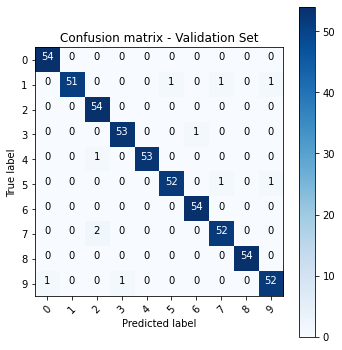

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
plot_confusion_matrix(confusion_matrix_val,
                      classes = [0,1,2,3,4,5,6,7,8,9],
                      normalize=False,
                      title='Confusion matrix - Validation Set',
                      cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[29  0  0  1  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 1  0 27  1  1  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  1  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  1  0  0  0  0 29  0]
 [ 1  0  0  0  0  0  0  1  0 28]]


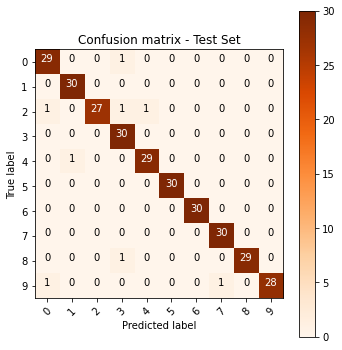

In [ ]:
plot_confusion_matrix(confusion_matrix_test,
                      classes = [0,1,2,3,4,5,6,7,8,9],
                      normalize=False,
                      title='Confusion matrix - Test Set',
                      cmap=plt.cm.Oranges)

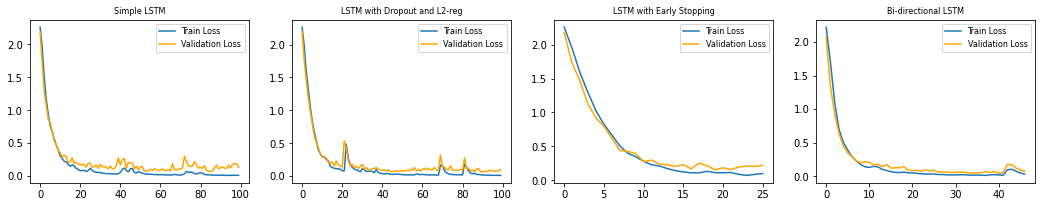

In [ ]:
# plot losses for all LSTMs
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,3))
axes[0].plot(np.arange(100), train_losses, '-', label='Train Loss')
axes[0].plot(np.arange(100), val_losses, '-', c='orange', label='Validation Loss')
axes[0].set_title('Simple LSTM', fontsize=8)
axes[0].legend(fontsize=8, frameon=True)

axes[1].plot(np.arange(100), train_losses_dropout_L2, '-', label='Train Loss')
axes[1].plot(np.arange(100), val_losses_dropout_L2, '-', c='orange', label='Validation Loss')
axes[1].set_title('LSTM with Dropout and L2-reg', fontsize=8)
axes[1].legend(fontsize=8, frameon=True)

axes[2].plot(np.arange(26), train_losses_early_check, '-', label='Train Loss')
axes[2].plot(np.arange(26), val_losses_early_check, '-', c='orange', label='Validation Loss')
axes[2].set_title('LSTM with Early Stopping', fontsize=8)
axes[2].legend(fontsize=8, frameon=True)

axes[3].plot(np.arange(47), train_losses_bidirect, '-', label='Train Loss')
axes[3].plot(np.arange(47), val_losses_bidirect, '-', c='orange', label='Validation Loss')
axes[3].set_title('Bi-directional LSTM', fontsize=8)
axes[3].legend(fontsize=8, frameon=True)

plt.show()

In [ ]:
# bonus step (8)
# first, we adapt the train and evaluate functions
def train3(model, dataloader, criterion, optimizer):    
    overall_loss = 0.0
    model.train()   # train mode
    for idx, batch in enumerate(dataloader, 1):

        inputs  = batch[0]
        labels  = batch[1]
        lengths = batch[2]
        
        optimizer.zero_grad()   # zero gradients out
        y_preds, indices = model(inputs, lengths) # compute Loss
        loss = criterion(y_preds, labels[indices]) # forward propagate
        loss.backward() # backpropagate
        optimizer.step()    # update parameters

        overall_loss += loss.data.item()

    return overall_loss/idx   # train loss

def evaluate3(model, dataloader, criterion):
    overall_loss = 0.0
    
    y_gold = []
    y_pred = []
    
    model.eval() # evaluation mode
    with torch.no_grad(): # do not compute gradients
        for idx, batch in enumerate(dataloader, 1):
            
            inputs  = batch[0]
            labels  = batch[1]
            lengths = batch[2]
                
            y_preds, indices = model(inputs, lengths)
            loss = criterion(y_preds, labels[indices])
            prediction = torch.argmax(y_preds, dim=1)
            overall_loss += loss.data.item()
            
            y_pred.append(prediction.numpy())
            y_gold.append(labels.numpy())

    return overall_loss / idx, (y_gold, y_pred)

In [ ]:
LSTM_quest8 = BasicLSTM(input_dim=input_dim, rnn_size=128, output_dim=10, num_layers=1, bidirectional=True, dropout=0.5, question8=True)
optimizer = torch.optim.Adam(LSTM_quest8.parameters(), lr=1e-3, weight_decay=1e-4)

train_losses_quest8 = []
val_losses_quest8 = []

opt_loss = np.inf
count = 0
for epoch in range(epochs):
    train_loss = train3(LSTM_quest8, train_loader, criterion, optimizer)
    val_loss, (y_gold, y_pred) = evaluate3(LSTM_quest8, val_loader, criterion)

    train_losses_quest8.append(train_loss)
    val_losses_quest8.append(val_loss)
    print("Epoch {}: Training Loss = {} \t--\t Validation Loss = {}".format(epoch, train_loss, val_loss))

    if val_loss < opt_loss:
        torch.save(LSTM_quest8, "./LSTM_quest8") # checkpoint
        opt_loss = val_loss
        count = 0
    else:
        count += 1
    
    if count == 6:  # if it doesn't get any better, stop so as not to overfit
        print(' !!-- Terminated Training due to Early Stopping --!! ')
        break

Epoch 0: Training Loss = 2.2207638516145596 	--	 Validation Loss = 2.0582791805267333
Epoch 1: Training Loss = 1.6711781796287088 	--	 Validation Loss = 1.2139490127563477
Epoch 2: Training Loss = 1.0083500953281628 	--	 Validation Loss = 0.7744403719902039
Epoch 3: Training Loss = 0.6354110275997835 	--	 Validation Loss = 0.538978886604309
Epoch 4: Training Loss = 0.41240223365671497 	--	 Validation Loss = 0.3424155116081238
Epoch 5: Training Loss = 0.28892896718838634 	--	 Validation Loss = 0.2916905879974365
Epoch 6: Training Loss = 0.2390316672184888 	--	 Validation Loss = 0.26401097476482394
Epoch 7: Training Loss = 0.16846979453283198 	--	 Validation Loss = 0.2205876260995865
Epoch 8: Training Loss = 0.15789898441118352 	--	 Validation Loss = 0.1979888528585434
Epoch 9: Training Loss = 0.12901916486375473 	--	 Validation Loss = 0.20081908702850343
Epoch 10: Training Loss = 0.11923477667219498 	--	 Validation Loss = 0.1576259508728981
Epoch 11: Training Loss = 0.09523879210738574 

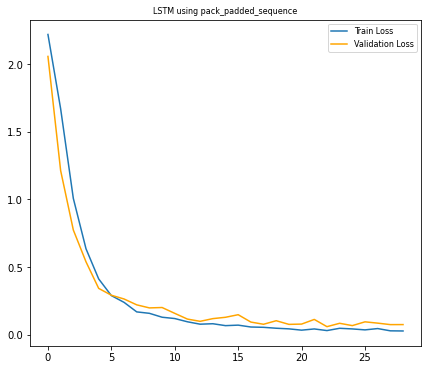

In [ ]:
# plot losses for all LSTMs
fig= plt.figure(figsize=(7,6))
plt.plot(np.arange(29), train_losses_quest8, '-', label='Train Loss')
plt.plot(np.arange(29), val_losses_quest8, '-', c='orange', label='Validation Loss')
plt.title('LSTM using pack_padded_sequence', fontsize=8)
plt.legend(fontsize=8, frameon=True)

plt.show()